# This notebook is kindly produced by Dr. Andrew Wang to fit measured ionic conductivity for EC:EMC:LiPF6 electrolyte in the following paper:
Wang, A. A., Greenbank, S., Li, G. C., Howey, D. A., & Monroe, C. W. (2022). Current-driven solvent segregation in lithium-ion electrolytes. Cell Reports Physical Science, 3(9), 12. doi:10.1016/j.xcrp.2022.101047

In [1]:
# import packages
import os, sys, platform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as skmetrics
from scipy.optimize import curve_fit
print('Python version', sys.version)
print('Running on', platform.system())

Python version 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
Running on Linux


In [2]:
# Load data, where d [=] g/ml, k [=] mS/cm
training_file = 'Ternary_Physicochemical_Training.csv'
df = pd.read_csv(training_file)
df = df[df.Temp==25] #Assuming isothermal model at 25C
df = df.reset_index(drop=True)

#Calculate molarity 
MLi = 151.905 #mol/g
MEC = 88.06 #mol/g
df['cLiPF6'] = df.xLiPF6*df.d*1000/MLi
df['cEC'] = df.xEC*df.d*1000/MEC

#Write dataframe to do symbolic regression on
data_df = pd.DataFrame()
data_df['cLi'] = df.cLiPF6*1000 #mol/L -> mol/m3
data_df['cEC'] = df.cEC*1000 #mol/L -> mol/m3
data_df['T'] = df['Temp']+273.15 #Kelvin
data_df['K'] = df.k*100/1000 #mS/cm -> S/m

li = data_df['cLi']
ec = data_df['cEC']
K = data_df['K']

R2: 
0.9004473641770168
RMSE: 
0.09984099248291026

PLOT 1: REGRESSION FITTING
conductivity S/m vs LiPF6 conc mol/m3


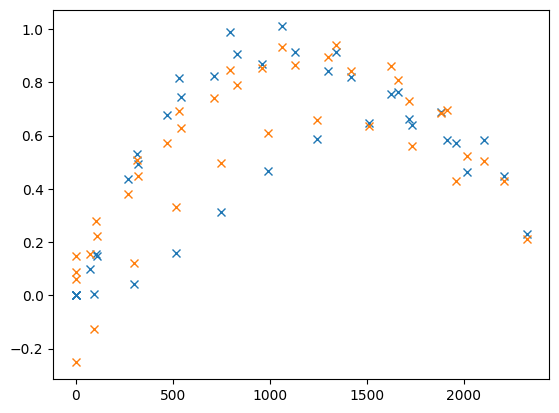


PLOT 2: COND VS LI CONC
conductivity S/m vs LiPF6 conc mol/m3


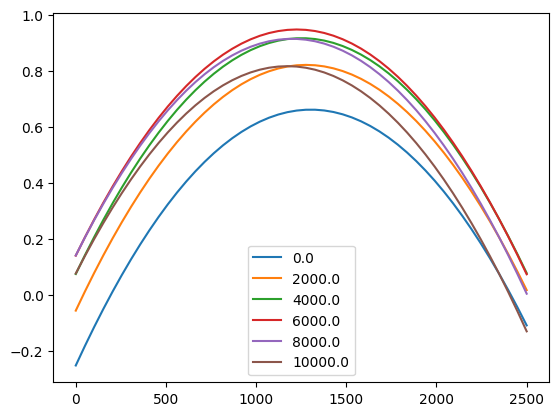

PLOT 3: COND VS EC CONC @ FIXED LI CONC 1 M
conductivity S/m vs EC conc mol/m3


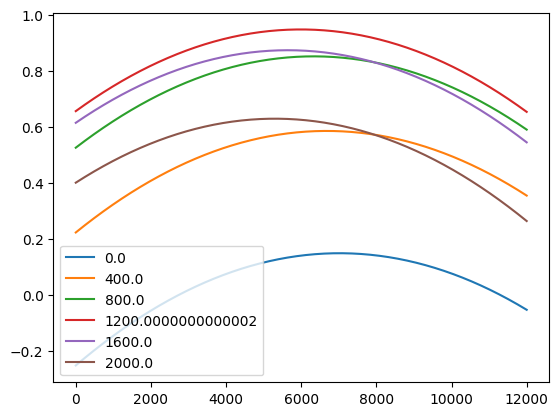

In [3]:
# 2nd DEGREE POLYNOMIAL MODEL
def func(X, b0,b1,b2,b3,b4,b5):
    li,ec = X
    return b0 + b1*li + b2*ec + b3*li*ec + b4*li*li + b5*ec*ec

p0 = [0,0,0,0,0,0]
popt, pcov = curve_fit(func, (li,ec), K, p0)

y_real = K #actual density
y_hat = func((li,ec), *popt) #predicted density

mse = skmetrics.mean_squared_error(y_real, y_hat)
r2 = skmetrics.r2_score(y_real, y_hat)
mape = skmetrics.mean_absolute_percentage_error(y_real, y_hat)

print('R2: ')
print(r2)
print('RMSE: ')
print(np.sqrt(mse))

plt.plot(li,y_real,'x')
plt.plot(li,y_hat,'x')
print('')
print('PLOT 1: REGRESSION FITTING')
print('==========================================')
print('conductivity S/m vs LiPF6 conc mol/m3')
plt.show()


'''
VISUALIZING TRENDS:
==================================

* EC molarity varies between 0 and 12 mol/L
* LiPF6 molarity varies between 0 and 2.5 mol/L
* This captures the peak conductivity around 6 mol/L EC
* Also captures sharp drop off at higher EC content
'''

ec_list = np.linspace(0,10,6)*1000
for i in ec_list:
    li_test = np.linspace(0,2500)
    ec_test = np.linspace(i,i)
    K_test = func((li_test,ec_test), *popt) #predicted density
    plt.plot(li_test,K_test,'-',label=str(i))
plt.legend()
print('')
print('PLOT 2: COND VS LI CONC')
print('==========================================')
print('conductivity S/m vs LiPF6 conc mol/m3')
plt.show()


li_list = np.linspace(0,2,6)*1000
for i in li_list:
    li_test = np.linspace(i,i)
    ec_test = np.linspace(0,12000)
    K_test = func((li_test,ec_test), *popt) #predicted density
    plt.plot(ec_test,K_test,'-',label=str(i))
plt.legend()
print('PLOT 3: COND VS EC CONC @ FIXED LI CONC 1 M')
print('==========================================')
print('conductivity S/m vs EC conc mol/m3')
plt.show()

In [4]:
'''
Here are the fitted coefficients
'''
print(popt)

[-2.52354874e-01  1.40212291e-03  1.14201470e-04 -1.39864475e-08
 -5.37935692e-07 -8.13632416e-09]


In [5]:
'''
Here is the overall equation with some possible tweaks

li = molarity of LiPF6 in mol/m3
ec = molarity of EC in mol/m3
cond = conductivity in S/m
all fitted at 25 degC
'''

def get_conductivity(li,ec):
    
    b0,b1,b2,b3,b4,b5 = np.array([-2.52354874e-01,  1.40212291e-03,  1.14201470e-04, -1.39864475e-08,
       -5.37935692e-07, -8.13632416e-09])
    
    cond = b0 + b1*li + b2*ec + b3*li*ec + b4*li*li + b5*ec*ec
    
    if cond<0: #catch negative conductivities
        cond = 0
    if li==0: #catch no charge carriers
        cond = 0
    
    return cond
    



PLOT 4: COND VS LI CONC
conductivity S/m vs LiPF6 conc mol/m3


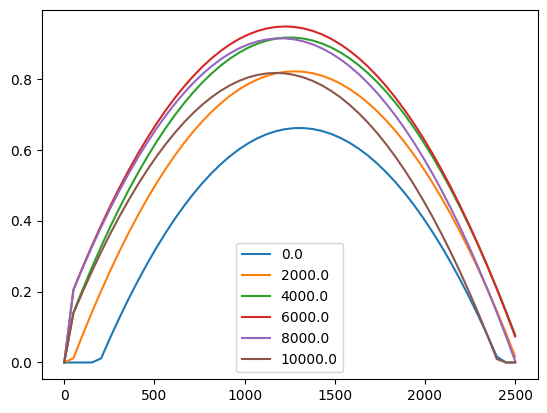

In [6]:
for i in ec_list:
    li_test = np.linspace(0,2500)
    ec_test = i
    K_test = [get_conductivity(i_li,ec_test) for i_li in li_test] #predicted density
    plt.plot(li_test,K_test,'-',label=str(i))
plt.legend()
print('')
print('PLOT 4: COND VS LI CONC')
print('==========================================')
print('conductivity S/m vs LiPF6 conc mol/m3')
plt.show()